In [53]:
import utils
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DIR_PATH = "Data"
DIRPATH_EXTRACTED_FEATURES = "extracted_features"

In [204]:
class CustomDataset():
    def __init__(self, brands: list, filenames_features: list, filename_target=utils.FILENAME_RELEVANCE_WINDOW, log_target=False, device=device):
        self.log_target = log_target
        tensor = torch.concat([torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_feature), map_location=device, weights_only=False) 
                                for filename_feature in filenames_features], dim=1)
                                  for brand in brands], dim=0)
        numpy_array = tensor.detach().numpy()
        features = pd.DataFrame(numpy_array)

        tensor = torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_target), map_location=device, weights_only=False) 
                                  for brand in brands], dim=0)
        numpy_array = tensor.detach().numpy()
        self.target = pd.DataFrame(numpy_array)
        if log_target:
              self.target = np.log(self.target)

        self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(features, self.target, test_size = 0.1)
    
    def __len__(self):
        return len(self.target)

class CustomRegressor():
    def __init__(self, range=None):
        if range: # gave errors when range was zero
            if range[0] == 0:
                range[0] += 0.001
        self.range = range
        self.regressor = RandomForestRegressor(
            n_estimators=100,
            criterion='squared_error',
            max_depth=None,
            min_samples_leaf=10,
            oob_score=True,
            random_state=0,
            )
        
    def fit(self, Data: CustomDataset):
        if self.range:
            if Data.log_target:
                target_range = np.log(self.range)
        target_train = Data.target_train.rename(columns={0:'target'})
        df = pd.concat([Data.features_train, target_train], axis=1)
        df = df[df['target'] > target_range[0]]
        df = df[df['target'] < target_range[1]]
        features_train = df.drop(columns=['target'])
        target_train = df['target']
        self.regressor.fit(features_train, target_train)

    def oob_score(self):
        print(f'Out-of-Bag Score: {self.regressor.oob_score_}')
        
    def score(self, Data: CustomDataset):
        if self.range:
            if Data.log_target:
                target_range = np.log(self.range)

        target_test = Data.target_test.rename(columns={0:'target'})
        df = pd.concat([Data.features_test, target_test], axis=1)
        df = df[df['target'] > target_range[0]]
        df = df[df['target'] < target_range[1]]
        features_test = df.drop(columns=['target'])
        target_test = df['target']

        predictions = self.regressor.predict(features_test)
        self.oob_score()
        mse = mean_squared_error(target_test, predictions)
        r2 = r2_score(target_test, predictions)
        print(f'Mean Squared Error: {mse}')
        print(f'R-squared: {r2}')

    def predict_train(self, Data: CustomDataset):
        return self.regressor.predict(Data.features_train)

    def predict_test(self, Data: CustomDataset):
        return self.regressor.predict(Data.features_test)
    
    def predict(self, Data):
        return self.regressor.predict(Data)
        

class CustomClassifier():
    def __init__(self, bins):
        self.bins = bins
        self.classifier = RandomForestClassifier(
            n_estimators=100,
            criterion='gini',
            max_depth=None,
            min_samples_leaf=10,
            oob_score=True,
            random_state=0,
        )
        
    def fit(self, Data: CustomDataset):
        if Data.log_target:
            train_bins = (Data.target_train).map(np.exp)
        else:
            train_bins = Data.target_train
        train_bins = pd.cut(train_bins[0], bins=self.bins, labels=[i for i in range(len(self.bins) - 1)])
        self.classifier.fit(Data.features_train, train_bins)

    def oob_score(self):
        print(f'Out-of-Bag Score: {self.classifier.oob_score_}')
        
    def score(self, Data: CustomDataset):
        if Data.log_target:
            train_bins = (Data.target_train).map(np.exp)
            test_bins = (Data.target_test).map(np.exp)
        else:
            train_bins = Data.target_train
            test_bins = Data.target_test
        train_bins = pd.cut(train_bins[0], bins=self.bins, labels=[i for i in range(len(self.bins) - 1)])
        test_bins = pd.cut(test_bins[0], bins=self.bins, labels=[i for i in range(len(self.bins) - 1)])

        target_train_pred = self.classifier.predict(Data.features_train)
        target_test_pred = self.classifier.predict(Data.features_test)
        train_accuracy = accuracy_score(train_bins, target_train_pred)
        test_accuracy = accuracy_score(test_bins, target_test_pred)

        self.oob_score()
        print("Train Accuracy: %.1f%%" %(train_accuracy * 100))
        print("Test Accuracy: %.1f%%" %(test_accuracy * 100))

    def predict_train(self, Data: CustomDataset):
        return self.classifier.predict(Data.features_train)

    def predict_test(self, Data: CustomDataset):
        return self.classifier.predict(Data.features_test)
    
    def predict(self, Data):
        return self.classifier.predict(Data)

In [117]:
filenames_features = [
    utils.FILENAME_BRAND_OHE,
    utils.FILENAME_PUBLICATION_TIMESTAMP,
    utils.FILENAME_PUBLICATION_WEEKDAY_OHE,
    utils.FILENAME_NUM_WORDS,
    utils.FILENAME_NUM_PARAGRAPH,
    # utils.FILENAME_MAIN_SECTION_OHE,
    # utils.FILENAME_SUBSECTIONS_OHE,
    # utils.FILENAME_LDA_TOPICS,
    # utils.FILENAME_IPTC_TOPICS_LEVEL_0,
    # utils.FILENAME_IPTC_TOPICS_LEVEL_1,
]

brands = utils.ALL_BRANDS
brands = ['ad']

In [122]:
Data = CustomDataset(brands, filenames_features, log_target=True)
Data.features_train.shape

(89209, 17)

In [210]:
regressor = CustomRegressor([0,50])
regressor.fit(Data)

In [198]:
classifier = CustomClassifier(bins=[0,50,100,1000])
classifier.fit(Data)

In [211]:
print('regressor:')
regressor.score(Data)
print('classifier:')
classifier.score(Data)

regressor:
Out-of-Bag Score: 0.0360299212063222
Mean Squared Error: 0.16304454919197747
R-squared: 0.03250571515284428
classifier:
Out-of-Bag Score: 0.8243226580277775
Train Accuracy: 82.6%
Test Accuracy: 82.2%


diff mean: 0    0.488441
dtype: float64, diff std: 0    0.470067
dtype: float64
diff mean: 0    0.442148
dtype: float64, diff std: 0    0.437471
dtype: float64


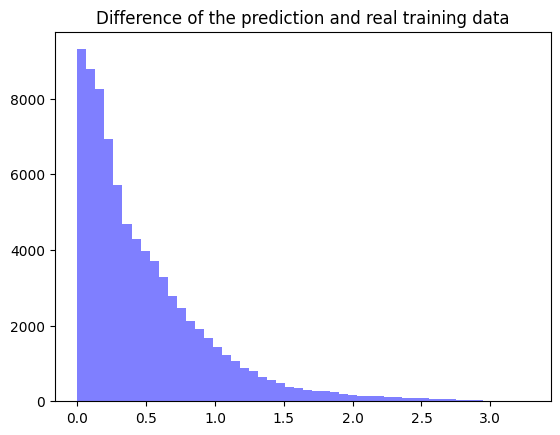

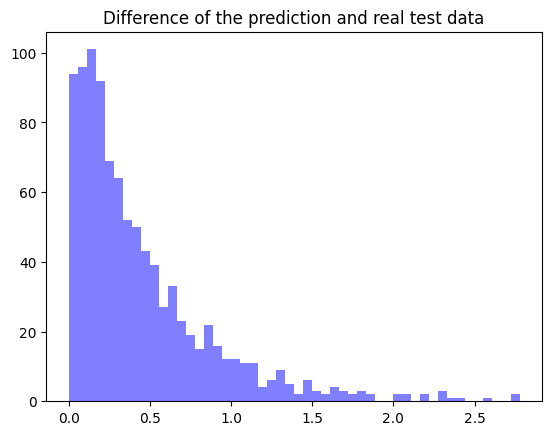

In [213]:
y_train = pd.DataFrame(Data.target_train)
y_pred_train = pd.DataFrame(regressor.predict_train(Data))
abs_dif_train = (y_pred_train - y_train).map(np.abs)

y_test = pd.DataFrame(Data.target_test)
y_pred_test = pd.DataFrame(regressor.predict_test(Data))
abs_dif_test = (y_pred_test - y_test).map(np.abs)

print(f'diff mean: {abs_dif_train.mean()}, diff std: {abs_dif_train.std()}')
print(f'diff mean: {abs_dif_test.mean()}, diff std: {abs_dif_test.std()}')
plt.hist(abs_dif_train, bins=50, alpha=0.5, color='b')
plt.title('Difference of the prediction and real training data')
plt.show()
plt.hist(abs_dif_test, bins=50, alpha=0.5, color='b')
plt.title('Difference of the prediction and real test data')
plt.show()

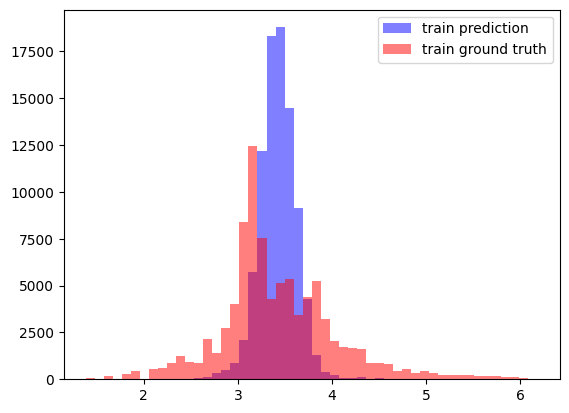

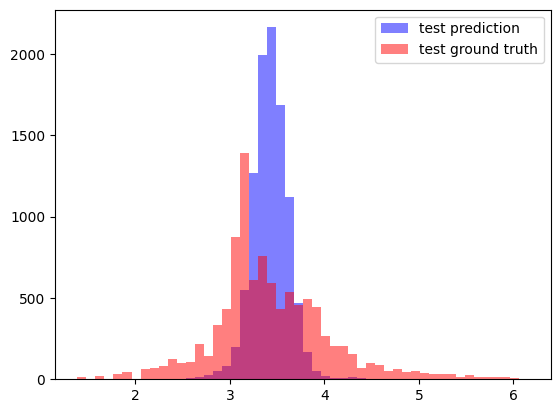

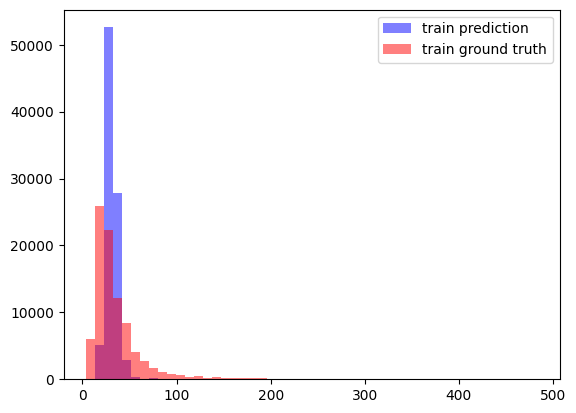

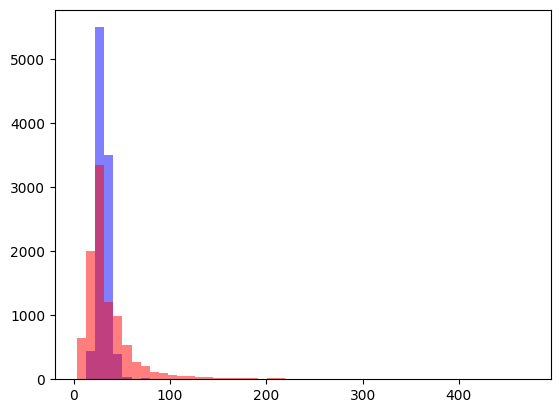

In [134]:
n_bins = 50
bins = np.histogram(np.hstack((y_pred_train,y_train)), bins=n_bins)[1]
plt.hist(y_pred_train, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test,y_test)), bins=n_bins)[1]
plt.hist(y_pred_test, bins=bins, alpha=0.5, color='b', label='test prediction')
plt.hist(y_test, bins=bins, alpha=0.5, color='r', label='test ground truth')
plt.legend()
plt.show()

if Data.log_target:
    y_pred_train_trans = (y_pred_train).map(np.exp)
    y_train_trans = (y_train).map(np.exp)
    y_pred_test_trans = (y_pred_test).map(np.exp)
    y_test_trans = (y_test).map(np.exp)
else:
    y_pred_train_trans = (y_pred_train).map(np.log)
    y_train_trans = (y_train).map(np.log)
    y_pred_test_trans = (y_pred_test).map(np.log)
    y_test_trans = (y_test).map(np.log)

bins = np.histogram(np.hstack((y_pred_train_trans,y_train_trans)), bins=n_bins)[1]
plt.hist(y_pred_train_trans, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train_trans, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test_trans,y_test_trans)), bins=n_bins)[1]
plt.hist(y_pred_test_trans, bins=bins, alpha=0.5, color='b')
plt.hist(y_test_trans, bins=bins, alpha=0.5, color='r')
plt.show()